Found 2219 validated image filenames belonging to 4 classes.
Found 392 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 566ms/step - accuracy: 0.2625 - loss: 5.9526 - val_accuracy: 0.3495 - val_loss: 3.1568
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 443ms/step - accuracy: 0.2854 - loss: 5.0919 - val_accuracy: 0.3495 - val_loss: 3.0148
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 453ms/step - accuracy: 0.3087 - loss: 4.7617 - val_accuracy: 0.3699 - val_loss: 2.7398
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - accuracy: 0.2968 - loss: 4.6243 - val_accuracy: 0.4158 - val_loss: 2.5138
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 446ms/step - accuracy: 0.3152 - loss: 4.2707 - val_accuracy: 0.4286 - val_loss: 2.2260
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 445ms/step - accuracy: 0.3396 - loss: 3.8347 - val_accuracy: 0.4541 - val_loss: 2.0801
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 453ms/step - accuracy: 0.3485 - loss: 3.8480 - val_accuracy: 0.4796 - val_loss: 1.8862
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 441ms/step - accuracy: 0.3432 - loss: 3.6458 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 348ms/step - accuracy: 0.9247 - loss: 0.2626
✅ Test Accuracy: 0.9265
📉 Test Loss: 0.2566
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.95      0.88      0.91       185
meningioma_tumor       0.88      0.90      0.89       188
        no_tumor       0.96      0.96      0.96       100
 pituitary_tumor       0.94      0.98      0.96       180

        accuracy                           0.93       653
       macro avg       0.93      0.93      0.93       653
    weighted avg       0.93      0.93      0.93       653



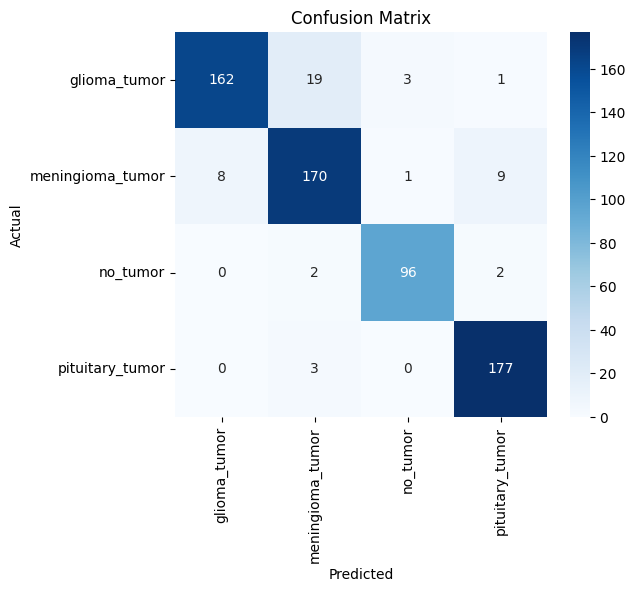

In [5]:

# ======================
# 🔄 Step 3: Data generators (STRONGER AUGMENTATION)
# ======================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                              target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical')
val_gen = valid_datagen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical', shuffle=False)

# ======================
# 🔧 Step 4: Build VGG16 model
# ======================
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
for layer in base_model.layers:
    layer.trainable = False  # freeze initially

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# ======================
# ⚙️ Step 5: Compile
# ======================
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ======================
# 📦 Step 6: Callbacks
# ======================
checkpoint = ModelCheckpoint('vgg16_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ======================
# 🏋️ Step 7: Train (Initial frozen training)
# ======================
EPOCHS = 15
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, earlystop])

# ======================
# 🔓 Step 8: Fine-tuning (Unfreeze deeper layers)
# ======================
for layer in base_model.layers[-8:]:
    layer.trainable = True  # unfreeze last layers for fine-tuning

model.compile(optimizer=Adam(learning_rate=1e-5),  # lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Optional: Compute class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['class']),
    y=train_df['class']
)
class_weights = dict(enumerate(class_weights))

# Fine-tune training
history_finetune = model.fit(train_gen,
                             validation_data=val_gen,
                             epochs=10,
                             callbacks=[checkpoint, earlystop],
                             class_weight=class_weights)

# ======================
# 🧪 Step 9: Evaluate on test set
# ======================
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")
print(f"📉 Test Loss: {loss:.4f}")

# ======================
# 🧾 Step 10: Classification report & confusion matrix
# ======================
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
